In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from functools import partial

from matplotlib import pyplot as plt

In [147]:
w      = np.diag([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
q_real = np.array([1,2,3, 5, 8, 4])
order  = 3

In [3]:
#scalar product with weights
def dot_w(a, b, w, q):
    return sum([a(q_) * b(q_) * w[i, i] for i, q_ in enumerate(q)])

In [180]:
class OrthoPolyRef:
    
    def __init__(self, parent_set, i, normed=False):
        self.parent_set = parent_set
        self.i          = i
        self.normed     = normed
    
    def __call__(self, q_):
        q = q_ if self.normed else self.parent_set.normed(q_)
        
        if isinstance(q, (list,tuple,np.ndarray)):
            return np.array([self.parent_set.get_result(self.i, q_) for q_ in q])
        
        return self.parent_set.get_result(self.i, q)

class OrthoPolyBase:
    
    def __init__(self, q, w, order):
        self.q_real = q
        self.w      = w
        
        self.order  = order
        
        self.a      = [np.nan] * (order + 1)
        self.b      = [np.nan] * (order + 1)
        self.c      = [np.nan] * (order + 1)
        
        self.cache  = { }
        
        self._calculate_initial_state ()
        self._calculate_params ()
    
    def normed(self, x):
        q_min, q_max = self.q_real.min(), self.q_real.max()
        return 2 * x / (q_max - q_min) - (q_max + q_min) / np.abs(q_max - q_min)
    
    def _calculate_initial_state (self):
        self.q = self.normed(self.q_real)
        
        self.b[0] = np.sqrt(self.w.sum())
        self.c[0] = 1 / self.b[0]
        
        for q in self.q:
            self.cache[(0, q)] = self.c[0]
    
    def _calculate_params(self):
        for i in range(0, self.order):
            P  = self
            qP = lambda q: q * P[i, True](q)
            
            a = dot_w(P[i, True], qP, self.w, self.q)
            c = 1 / np.sqrt( dot_w(qP, qP, self.w, self.q) - a**2 - (b**2 if i > 0 else 0) )
            b = 1 / c
            
            self.a[i+1] = a
            self.b[i+1] = b
            self.c[i+1] = c
            
            for q in self.q:
                self.cache[(i+1, q)] = c * ((q-a) * P[i, True](q) - (self.b[i] * P[i-1, True](q) if i > 0 else 0))
    
    def _calculate_result(self, i, q):
        P  = self
        
        if i == 0:
            return self.c[0]
        
        return self.c[i] * ((q - self.a[i]) * P[i-1, True](q) - (self.b[i-1] * P[i-2, True](q) if i > 1 else 0))
    
    def get_result(self, i, x):
        #cache the q points
        if x in self.q_real:
            if (i, x) not in self.cache:
                self.cache[(i, x)] = self._calculate_result(i, x)
            
            return self.cache[(i, x)]
        else:
            return self._calculate_result(i, x)
    
    def __getitem__(self, order):
        normed = False
        
        if isinstance(order, (tuple, list, np.ndarray)) and len(order) > 1:
            normed = order[1]
            order  = order[0]
        
        return OrthoPolyRef(self, order, normed)
    
    def plot_functions (self, ax):
        x=np.linspace(self.q_real.min(), self.q_real.max(), 100)
        
        for i in range(self.order+1):
            ax.plot(x, self[i](x))
        
        plt.xlabel("q");
        
        ax2 = ax.twiny()
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks(self.q_real)
        ax2.set_xticklabels( ["%.2f" % q for q in self.q])
        ax2.set_xlabel("$q_{\mathrm{norm}}$")

In [181]:
base = OrthoPolyBase(q_real, w, order)

## Tests

#### 0. order cached

In [71]:
base[0](1)

1.0000000000000002

#### 0. order non-cached

In [72]:
base[0](0.12345346724727)

1.0000000000000002

#### 1. order cached

In [73]:
base[1](1)

-1.4638501094227998

#### 1. order non-cached

In [74]:
base[1](0.12345346724727)

-1.9771032045765036

#### Cache

In [75]:
base.cache

{(0, -0.9999999999999999): 1.0000000000000002,
 (0, -0.5999999999999999): 1.0000000000000002,
 (0, -0.19999999999999996): 1.0000000000000002,
 (0, 0.6000000000000001): 1.0000000000000002,
 (0, 1.0): 1.0000000000000002,
 (0, 0.20000000000000018): 1.0000000000000002,
 (1, -0.9999999999999999): -1.4638501094227998,
 (1, -0.5999999999999999): -0.8783100656536799,
 (1, -0.19999999999999996): -0.2927700218845601,
 (1, 0.6000000000000001): 0.8783100656536799,
 (1, 1.0): 1.4638501094227996,
 (1, 0.20000000000000018): 0.2927700218845601,
 (2, -0.9999999999999999): 1.3363062095621219,
 (2, -0.5999999999999999): -0.267261241912425,
 (2, -0.19999999999999996): -1.0690449676496983,
 (2, 0.6000000000000001): -0.2672612419124246,
 (2, 1.0): 1.3363062095621219,
 (2, 0.20000000000000018): -1.0690449676496983,
 (3, -0.9999999999999999): -0.9128709291752771,
 (3, -0.5999999999999999): 1.2780193008453875,
 (3, -0.19999999999999996): 0.7302967433402215,
 (3, 0.6000000000000001): -1.2780193008453873,
 (3, 1

#### Polynomials

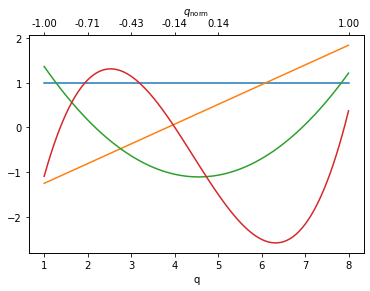

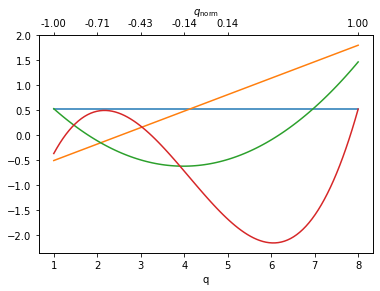

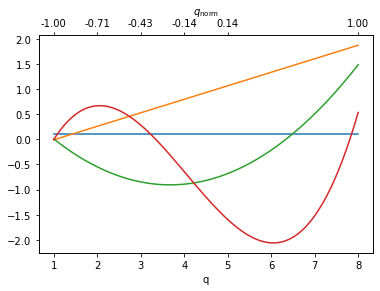

In [184]:
OrthoPolyBase(q_real, w, order).plot_functions(plt.gca())
plt.savefig("figures/ortho_poly_1.svg", bbox_inches="tight")
plt.show()

w_   = np.diag([1, 1, 1, 1/6, 1/6, 1/6])
OrthoPolyBase(q_real, w_, order).plot_functions(plt.gca())
plt.savefig("figures/ortho_poly_2.svg", bbox_inches="tight")
plt.show()

w_   = np.diag([100, 1, 1/6, 1/6, 1/6, 1/6])
OrthoPolyBase(q_real, w_, order).plot_functions(plt.gca())
plt.savefig("figures/ortho_poly_3.svg", bbox_inches="tight")
plt.show()

# Fitting

In [77]:
Y = np.array([1,2,3,4, 10, 12])

In [78]:
np.kron(Y, Y[:, np.newaxis]).sum()

1024

In [79]:
base[0](q_real)

array([1., 1., 1., 1., 1., 1.])

In [80]:
np.kron(Y[:, np.newaxis], q_real) * w

array([[ 0.16666667,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.66666667,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  1.5       ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  3.33333333,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 10.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         8.        ]])

In [174]:
B   = [(np.kron(Y[:, np.newaxis], base[z](q_real)) * w).sum() for z in range(order+1)]
Phi = [[(np.kron(base[r](q_real)[:, np.newaxis], base[z](q_real)) * w).sum() for z in range(order+1)] for r in range(order+1)]